In [1]:
# importing Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
from io import BytesIO

In [2]:
url = "https://raw.githubusercontent.com/adamajane/social-graphs-and-interactions-02805-assignments/refs/heads/main/assignment_1/Files/artists_graph_with_stats.gexf"

# Fetch file from GitHub
response = requests.get(url)
response.raise_for_status()  

# Load into NetworkX
G = nx.read_gexf(BytesIO(response.content))
print(f"Loaded remote graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Loaded remote graph: 484 nodes, 7328 edges


# Process Documentation

### Step-by-step procedure

The process of crawling the Wikipedia rock performer network involved several distinct stages. First, the list of mainstream rock performers was obtained from the dedicated Wikipedia page. Using regular expressions, all internal Wikipedia links corresponding to performers were extracted. These raw links were then cleaned by removing duplicates and filtering out irrelevant categories, templates, and non-performer links.

Next, each performer’s Wikipedia page was retrieved using the MediaWiki API. To ensure consistency, the pages were saved locally as plain text files in a structured directory, with one file per performer. A filename normalization function was applied to handle problematic characters such as slashes, spaces, or special symbols, ensuring that all files could be saved and later accessed without errors.

Once all the performer pages were collected, a second round of regular expression parsing was applied to each file to extract outgoing links. These links were cross-checked against the cleaned list of performer names to ensure that only relevant connections between rock performers were retained. The resulting connections were stored in a directed NetworkX graph, where nodes represent performers and edges represent references from one performer’s page to another.

Additional node attributes were then introduced. Specifically, the word count of each Wikipedia page was calculated and stored as a feature for the corresponding node. This allowed the network to capture not only relational information but also content size. Isolated nodes—performers with no incoming or outgoing links—were subsequently identified and removed to ensure the network contained only meaningful connections. Finally, the largest weakly connected component was extracted to provide a robust structure for subsequent statistical analysis and visualization.

### Most difficult part

The most challenging aspect of the process was handling inconsistencies in performer names and file saving. Wikipedia page titles often contain special characters (e.g., “AC/DC”), spaces, or disambiguation tags (e.g., “(band)”), which complicated both file naming and link matching. Without normalization, many files could not be accessed later, leading to incomplete results. Another challenge was filtering out non-performer links that persisted in the text despite cleaning efforts. Ensuring that only valid performer-to-performer edges were included required multiple rounds of debugging and refinement.

Another source of complexity was managing structural issues in the graph itself. The presence of isolated nodes required careful verification to confirm that they were not artifacts of missing data but genuinely disconnected performers. Furthermore, extracting the largest weakly connected component involved confirming that no relevant substructures were excluded from analysis. These steps added extra layers of decision-making and validation to the workflow.

### Use of LLM

Large Language Models were used as a support tool to speed up repetitive or technical tasks such as drafting regular expressions, suggesting file-normalization functions, and structuring the network-building code. LLMs also assisted in planning the sequence of operations, such as when to add word count attributes, remove isolated nodes, and extract the largest component.

All outputs were cross-checked against actual Wikipedia text and verified through manual testing to ensure correctness. This approach allowed the automation of boilerplate tasks while maintaining full control over the interpretation of results. In practice, the LLM reduced development time but final decisions on filtering, graph cleaning, and component extraction were based on manual verification.

### Reflection and improvements

If the process were repeated, three improvements would be prioritized. First, more robust data validation could be added, for example by cross-referencing extracted performer names with official Wikipedia categories (e.g., “Category:Rock_music_groups”) to avoid including non-performer pages. Second, instead of saving plain-text files, a lightweight database or structured JSON format could be used to store both raw page content and metadata, simplifying queries and updates. Third, automated handling of redirects and missing files would reduce manual intervention, especially for problematic pages with special characters.

In addition, the inclusion of word count as a node attribute could be expanded into richer textual metrics such as sentiment or topic analysis. Removing isolated nodes and working only with the largest connected component was a practical choice, but future work could investigate whether smaller disconnected subgraphs contain interesting stylistic or regional clusters. These refinements would improve reproducibility, minimize manual cleanup, and expand the analytical potential of the network.

## process breakdown

The performer network was built from the List of mainstream rock performers page on Wikipedia. The wikitext of the page was fetched through the Wikipedia API, and a regular expression was applied to extract all internal wiki-links. To avoid including irrelevant pages, links starting with prefixes such as Category: (e.g., Category:Rock music groups), Template: (e.g., Template:Rock music), File: (e.g., File:Band_photo.jpg), or Wikipedia: (e.g., Wikipedia:Neutral point of view) were filtered out. A manual exclusion list was also created to remove links to general concepts like rock music, Heavy Metal, singles, or album charts. These were identified by checking ambiguous cases directly on Wikipedia. After this filtering, the dataset contained 488 unique performers.

For each artist, the full wikitext page was downloaded and stored as a text file. Filename sanitization was necessary to handle problematic characters, for example replacing the slash in AC/DC with an underscore. This solved one of the main technical difficulties in the data collection stage.

Edges were generated by scanning each text file for outgoing wiki-links, keeping only those that pointed to other performers in the curated list. Multiple mentions to the same artist were treated as a single edge, and self-loops were removed. The resulting directed graph had 488 nodes and 7,328 edges. Node attributes such as the word count of the Wikipedia entry were added, and structural measures including in-degree, out-degree, PageRank, and betweenness centrality were calculated. To focus on the main structure, isolated nodes were removed and the largest weakly connected component was selected for analysis.

Finally, the network was exported to the GEXF format, which preserves both the structure and the node attributes. This allowed the dataset to be uploaded to GitHub, from where it directly in the Jupyter Notebook for the statistical analysis and plots.

# Summary Statistics

Basic statistics - Number of links and nodes and also average degree.  

In [3]:
# Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = G.number_of_edges() / G.number_of_nodes()

print(f"Number of nodes in the network: {num_nodes}")
print(f"Number of links in the network: {num_edges}")
print("Average degree:", avg_degree)

Number of nodes in the network: 484
Number of links in the network: 7328
Average degree: 15.140495867768594


The network contains 484 nodes (artists) and 7,328 directed edges (links between artists). This gives an average degree of about 15.1, meaning that, on average, each artist’s Wikipedia page links to around 15 other performers in the network.

In [11]:
# Network properties
density = nx.density(G)
clustering = nx.average_clustering(G.to_undirected())

# Diameter of largest weakly connected component
largest_component = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_component).to_undirected()
diameter = nx.diameter(H)

print(f"Density of the network: {density:.4f}")
print(f"Average clustering coefficient: {clustering:.4f}")
print(f"Diameter of the largest component: {diameter}")


Density of the network: 0.0313
Average clustering coefficient: 0.2353
Diameter of the largest component: 5


The network has a density of 0.0313, meaning it is quite sparse, with only about 3% of all possible links present. The average clustering coefficient is 0.2353, which shows a moderate level of local grouping between artists. The diameter of the largest component is 5, so even in the biggest part of the network, any two artists are at most five steps apart.

Reciprocity - Tells how many links are mutual between artists

In [12]:
# Reciprocity: fraction of edges that are mutual (A→B and B→A)
reciprocity = nx.reciprocity(G)
print(f"Reciprocity of the network: {reciprocity:.4f}")

Reciprocity of the network: 0.3556


The reciprocity of the network is 0.3556, which means that about 36% of the links between artists are mutual i.e., if one artist’s page links to another, there is roughly a one-third chance that the second artist also links back. This suggests that while many connections are one-way references, there is still a noticeable amount of two-way linking between performers.

Components - Shows how many disconnected groups exist and their sizes

In [13]:
# Connected components: weakly and strongly connected parts of the network
num_weak = nx.number_weakly_connected_components(G)
num_strong = nx.number_strongly_connected_components(G)
largest_weak_size = len(max(nx.weakly_connected_components(G), key=len))
largest_strong_size = len(max(nx.strongly_connected_components(G), key=len))

print(f"Weakly connected components: {num_weak} (largest size = {largest_weak_size})")
print(f"Strongly connected components: {num_strong} (largest size = {largest_strong_size})")

Weakly connected components: 1 (largest size = 484)
Strongly connected components: 24 (largest size = 461)


The network has 1 weakly connected component, meaning all 484 artists are at least indirectly connected if edge directions are ignored. There are 24 strongly connected components, with the largest containing 461 artists, which shows that most artists are part of a big core where links can be followed in both directions, while a few smaller groups remain more isolated.

Average Shortest Path Length - Gives the “typical” distance between artists, complementing diameter

In [14]:
# Average shortest path length on the largest weakly connected component (undirected)
H = G.subgraph(max(nx.weakly_connected_components(G), key=len)).to_undirected()
avg_path_len = nx.average_shortest_path_length(H)
print(f"Average shortest path length (largest component, undirected): {avg_path_len:.4f}")

Average shortest path length (largest component, undirected): 2.3693


The average shortest path length in the largest component is 2.37, which means that on average, any two artists in the network can be connected through fewer than three steps. This highlights the small-world nature of the network, where artists are typically only a couple of links apart.

Degree Assortativity - Shows whether high-degree artists link to other high-degree artists

In [15]:
# Pearson correlation of degrees at both ends of edges
assortativity = nx.degree_pearson_correlation_coefficient(H)
print(f"Degree assortativity coefficient: {assortativity:.4f}")

Degree assortativity coefficient: 0.0086


The degree assortativity coefficient is 0.0086, which is very close to zero. This indicates that there is essentially no clear tendency for high-degree artists to connect preferentially with other high-degree artists or with low-degree ones. In other words, links in the network appear to be placed without strong degree-based preference.

Transitivity (Global Clustering) - Measures overall triadic closure: ratio of closed triangles to possible triangles

In [16]:
# Global clustering (transitivity) on the undirected largest component
transitivity = nx.transitivity(H)
print(f"Transitivity (global clustering): {transitivity:.4f}")

Transitivity (global clustering): 0.2027


The global clustering coefficient (transitivity) is 0.2027, meaning that about 20% of all possible triangles in the network are actually closed. This shows that there is some tendency for artists to form interconnected groups, but the overall level of triadic closure is relatively modest.

In-degree Histogram Plot

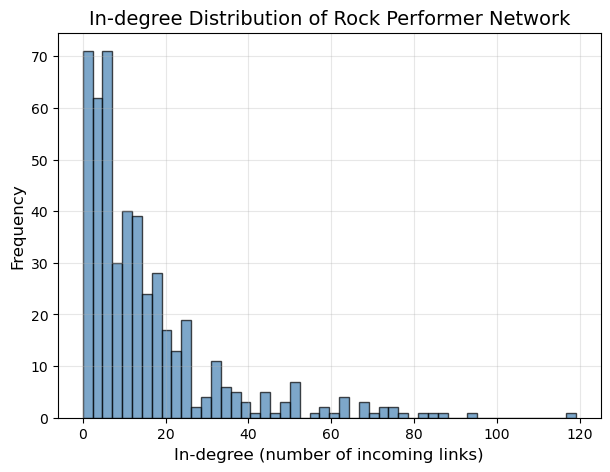

In [4]:
# Compute degree sequences
in_degrees = [d for n, d in G.in_degree()]

# Plot histogram of in-degree
plt.figure(figsize=(7,5))
plt.hist(in_degrees, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.title("In-degree Distribution of Rock Performer Network", fontsize=14)
plt.xlabel("In-degree (number of incoming links)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

The in-degree distribution is highly right skewed, with most artists receiving only a small number of incoming links, while a few well known performers attract a very large number. This creates a heavy tailed pattern that suggests the presence of preferential attachment, where already popular or influential artists are more likely to gain new links. The result is a network structure in which a small set of hubs dominate incoming references, while the majority of artists remain relatively less connected.

Out-degree Histogram plot

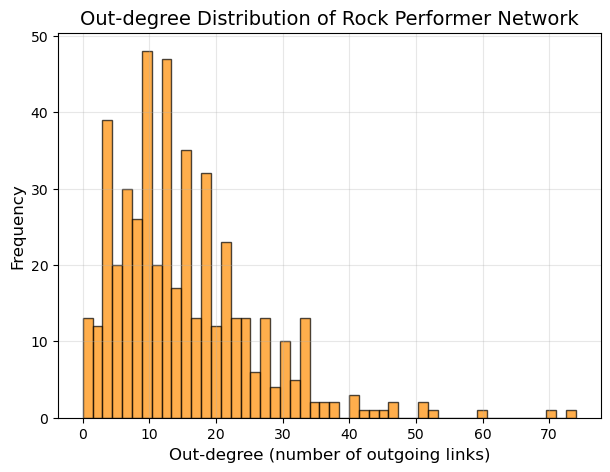

In [5]:
# Compute degree sequences
out_degrees = [d for n, d in G.out_degree()]


# Plot histogram of out-degree
plt.figure(figsize=(7,5))
plt.hist(out_degrees, bins=50, color="darkorange", edgecolor="black", alpha=0.7)
plt.title("Out-degree Distribution of Rock Performer Network", fontsize=14)
plt.xlabel("Out-degree (number of outgoing links)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

The out-degree distribution is less skewed and more evenly spread compared to the in-degree distribution. Many artists have a moderate number of outgoing links, which reflects how Wikipedia pages often include references to related acts, influences, or collaborations. Unlike in-degree, which reflects performer popularity, the out-degree mainly depends on how detailed or well-edited a page is, leading to a smoother distribution.

Comparison of Out-degree with a random network

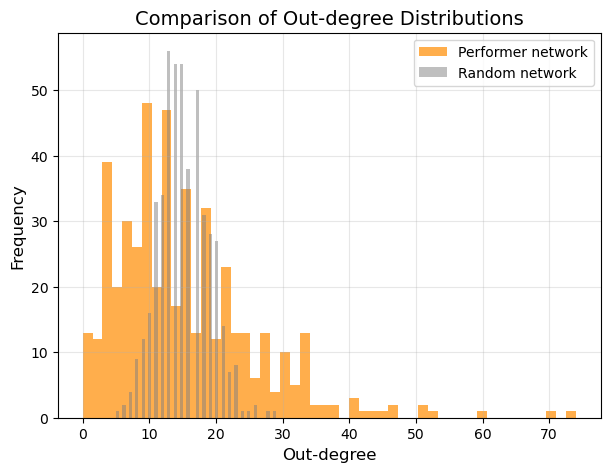

In [6]:
# Generate random network with same N, M
random_graph = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
random_out_degrees = [d for n, d in random_graph.out_degree()]

plt.figure(figsize=(7,5))
plt.hist(out_degrees, bins=50, alpha=0.7, label="Performer network", color="darkorange")
plt.hist(random_out_degrees, bins=50, alpha=0.5, label="Random network", color="gray")
plt.title("Comparison of Out-degree Distributions", fontsize=14)
plt.xlabel("Out-degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

When compared to a random network with the same size, the out-degree distribution of the performer network is noticeably broader and more uneven. The random network shows a narrow peak around the average degree, as expected from its uniform linking pattern, while the performer network has a wider spread with many nodes having very high or very low out-degrees. This difference highlights that the performer network is not random but shaped by editorial choices, with some pages linking to a large number of related artists while others contain far fewer references.

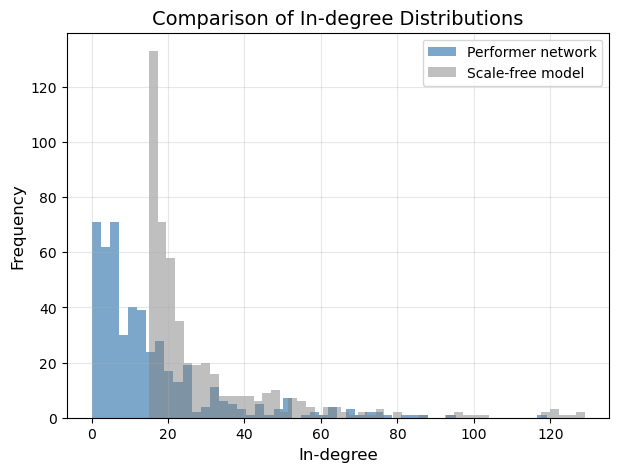

In [7]:
# Barabási-Albert scale-free model (approximation for in-degree distribution)
scale_free = nx.barabasi_albert_graph(num_nodes, int(num_edges/num_nodes))
scale_free_in_degrees = [d for n, d in scale_free.degree()]

plt.figure(figsize=(7,5))
plt.hist(in_degrees, bins=50, alpha=0.7, label="Performer network", color="steelblue")
plt.hist(scale_free_in_degrees, bins=50, alpha=0.5, label="Scale-free model", color="gray")
plt.title("Comparison of In-degree Distributions", fontsize=14)
plt.xlabel("In-degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The in-degree distribution of the performer network shows a heavy-tailed shape similar to the scale-free model, with many artists receiving only a few links and a few hubs accumulating very large numbers. However, the performer network deviates from the smooth pattern of the model, especially in the middle range, where the distribution is more irregular. This suggests that while the network broadly reflects preferential attachment, real-world editorial and cultural factors produce variations not captured by the pure scale-free model.

In [8]:
# Top 10 by in-degree
top_in = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
# Top 10 by out-degree
top_out = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 performers by in-degree:")
for name, deg in top_in:
    print(f"{name}: {deg}")

print("\nTop 10 performers by out-degree:")
for name, deg in top_out:
    print(f"{name}: {deg}")


Top 10 performers by in-degree:
Led Zeppelin: 119
Bob Dylan: 95
Queen (band): 88
Metallica: 85
David Bowie: 83
Jimi Hendrix: 77
Black Sabbath: 74
Nirvana (band): 74
U2: 73
Kiss (band): 72

Top 10 performers by out-degree:
Alice in Chains: 74
Deep Purple: 71
Black Sabbath: 60
Def Leppard: 52
Bryan Adams: 51
Guns N' Roses: 51
Metallica: 47
Rush (band): 47
Queen (band): 45
The Smashing Pumpkins: 44


The in-degree ranking highlights famous and influential artists like Led Zeppelin, Bob Dylan, and Queen, who receive the most incoming links from other performers. The out-degree ranking instead reflects pages with many outgoing references, such as Alice in Chains and Deep Purple, which include long lists of related acts and influences. A few bands like Metallica, Queen, and Black Sabbath appear in both lists, showing that they are both highly influential and well connected in the network.

In [ ]:
top_content = sorted(G.nodes(data=True), key=lambda x: x[1].get("word_count", 0), reverse=True)[:10]

print("Top 10 longest Wikipedia entries:")
for node, attr in top_content:
    print(f"{node}: {attr['word_count']} words")


Top 10 longest Wikipedia entries:
Guns N' Roses: 60853 words
Coldplay: 47028 words
Marilyn Manson (band): 46032 words
Queen (band): 45896 words
The Rolling Stones: 44022 words
U2: 43048 words
Bob Dylan: 42509 words
David Bowie: 42408 words
Paul McCartney: 42396 words
Elton John: 41255 words


The longest Wikipedia entries belong to globally popular artists such as Guns N’ Roses, Coldplay, and Queen, each with tens of thousands of words. These long pages reflect not only their cultural importance but also the extensive documentation of their careers, discographies, and influence. The overlap with top in-degree performers like Queen, Bob Dylan, and David Bowie shows that highly influential artists also tend to have more detailed Wikipedia coverage.